# 1 TOC

In [1]:
# Load required libraries
import numpy as np
import pandas as pd

In [68]:
consolidated_proba_df = pd.read_csv('consolidated_proba.csv')

In [69]:
consolidated_proba_df.head()

,row_id,Actual,gnb_proba,dt_le_proba,rf_proba,xgb_proba
0,20810,0,0.000717,0.000000,0.010149,0.000370
1,2860,0,0.071479,0.298246,0.158832,0.163852
2,4408,0,0.001196,0.020000,0.081508,0.001682
3,25747,0,0.013395,0.600000,0.502880,0.019145
4,23441,0,0.005260,0.000000,0.008383,0.000821


In [92]:
from KUtils.common import blend_util
import importlib
importlib.reload(blend_util)

<module 'KUtils.common.blend_util' from 'D:\\projects\\datascience\\kesh-utils\\KUtils\\common\\blend_util.py'>

In [93]:
best_blend_df = blend_util.find_best_stacking_blend(consolidated_proba_df, 
                                                    actual_target_column_name='Actual', 
                                                    columns_to_blend=['gnb_proba', 'dt_le_proba', 'rf_proba', 'xgb_proba'],
                                                    starting_weight=1,
                                                    max_weight=10,
                                                    step_weight=1,
                                                    minimize_loss='rmse', # other option mae
                                                    verbose=False
                                                   )

Running...
..........Have patience - Brute force with all combination will take time-

Final Best blend coefficients found at 
          rmse gnb_proba dt_le_proba rf_proba xgb_proba
16  0.00319803         1           1       10         6
With least error 16    0.00319803
Name: rmse, dtype: object
Done


In [87]:
best_blend_df.tail()

,rmse,gnb_proba,dt_le_proba,rf_proba,xgb_proba
12,0.0943696,1,1,7,5
13,0.0943129,1,1,8,5
14,0.0942923,1,1,9,5
15,0.094281,1,1,9,6
16,0.0942455,1,1,10,6


In [109]:
consolidated_proba_df['final_blended_proba'] = (consolidated_proba_df['gnb_proba']*1 + 
                                                consolidated_proba_df['dt_le_proba']*1 + consolidated_proba_df['rf_proba']*10 + consolidated_proba_df['xgb_proba']*6)/18

In [131]:
consolidated_proba_df.head(12)

,row_id,Actual,gnb_proba,dt_le_proba,rf_proba,xgb_proba,final_blended_proba,predicted
0,20810,0,0.000717,0.000000,0.010149,0.000370,0.005802,0
1,2860,0,0.071479,0.298246,0.158832,0.163852,0.163398,1
2,4408,0,0.001196,0.020000,0.081508,0.001682,0.047020,0
3,25747,0,0.013395,0.600000,0.502880,0.019145,0.319837,0
4,23441,0,0.005260,0.000000,0.008383,0.000821,0.005223,0
5,1825,0,0.011017,0.272727,0.258018,0.410049,0.295790,0
6,8438,0,0.001911,0.007859,0.006450,0.021352,0.011243,0
7,16783,0,0.000630,0.040816,0.034851,0.000213,0.021735,0
8,145,0,0.000007,0.073684,0.055773,0.001489,0.035575,0
9,380,1,0.533800,0.650794,0.616338,0.713054,0.645906,1


# Extra

In [133]:
import matplotlib.pyplot as plt
from KUtils.logistic_regression import auto_logistic_regression as autoglm

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, recall_score, precision_score

### Plots of Gaussian Naive Bayes

In [113]:
# First(0) column contains prob for 0-class and second(1) contains prob for 1-class
gnb_pred_df = pd.DataFrame({'Actual':consolidated_proba_df['Actual'], 'Probability':consolidated_proba_df['gnb_proba']}) 
return_dictionary = autoglm.calculateGLMKpis(gnb_pred_df, cutoff_by='Sensitivity-Specificity', include_cutoff_df_in_return=True)
cutoff_df = return_dictionary['cutoff_df']

probability_cutoff:0.04


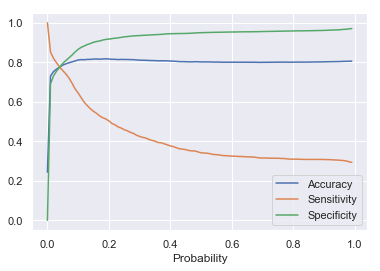

In [114]:
cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

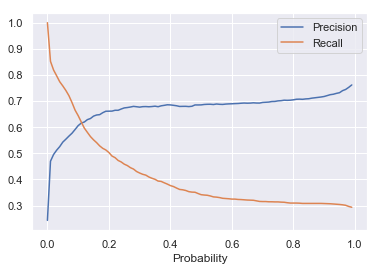

In [115]:
cutoff_df.plot.line(x='Probability', y=['Precision','Recall'])
plt.show()

In [136]:
prob_column='gnb_proba'
prob_cutoff = 0.04
consolidated_proba_df['predicted'] = consolidated_proba_df[prob_column].map(lambda x: 1 if x > prob_cutoff else 0)

local_confusion_matrix = metrics.confusion_matrix(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'] )
        
accuracy = metrics.accuracy_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
precision = metrics.precision_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
recall = metrics.recall_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
f1_score = metrics.f1_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
roc_auc = metrics.roc_auc_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])

print(" Accuracy {0:.3f}, \n Precision {1:.3f}, \n Recall {2:.3f}, \n f1_score {3:.3f}, \n roc_auc {4:.3f}".format(
    accuracy, precision,recall,f1_score,roc_auc))

 Accuracy 0.775, 
 Precision 0.526, 
 Recall 0.774, 
 f1_score 0.626, 
 roc_auc 0.775


### Plots of Random Forest

In [137]:
# First(0) column contains prob for 0-class and second(1) contains prob for 1-class
gnb_pred_df = pd.DataFrame({'Actual':consolidated_proba_df['Actual'], 'Probability':consolidated_proba_df['rf_proba']}) 
return_dictionary = autoglm.calculateGLMKpis(gnb_pred_df, cutoff_by='Sensitivity-Specificity', include_cutoff_df_in_return=True)
cutoff_df = return_dictionary['cutoff_df']

probability_cutoff:0.3


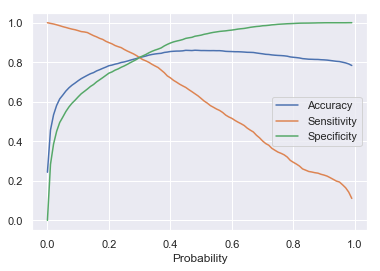

In [128]:
cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

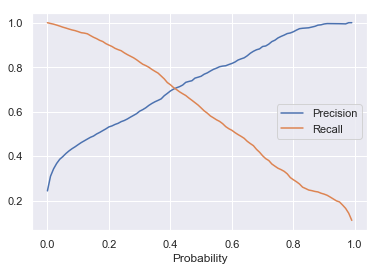

In [129]:
cutoff_df.plot.line(x='Probability', y=['Precision','Recall'])
plt.show()

In [138]:
prob_column='rf_proba'
prob_cutoff = 0.3
consolidated_proba_df['predicted'] = consolidated_proba_df[prob_column].map(lambda x: 1 if x > prob_cutoff else 0)

local_confusion_matrix = metrics.confusion_matrix(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'] )
        
accuracy = metrics.accuracy_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
precision = metrics.precision_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
recall = metrics.recall_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
f1_score = metrics.f1_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
roc_auc = metrics.roc_auc_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])

print(" Accuracy {0:.3f}, \n Precision {1:.3f}, \n Recall {2:.3f}, \n f1_score {3:.3f}, \n roc_auc {4:.3f}".format(
    accuracy, precision,recall,f1_score,roc_auc))

 Accuracy 0.824, 
 Precision 0.602, 
 Recall 0.823, 
 f1_score 0.695, 
 roc_auc 0.824


### Plots of XGB

In [139]:
# First(0) column contains prob for 0-class and second(1) contains prob for 1-class
gnb_pred_df = pd.DataFrame({'Actual':consolidated_proba_df['Actual'], 'Probability':consolidated_proba_df['xgb_proba']}) 
return_dictionary = autoglm.calculateGLMKpis(gnb_pred_df, cutoff_by='Sensitivity-Specificity', include_cutoff_df_in_return=True)
cutoff_df = return_dictionary['cutoff_df']

probability_cutoff:0.2


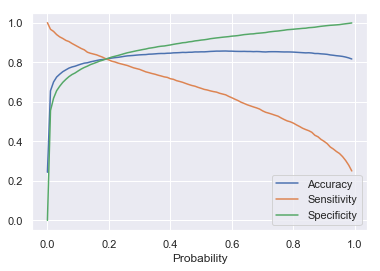

In [140]:
cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

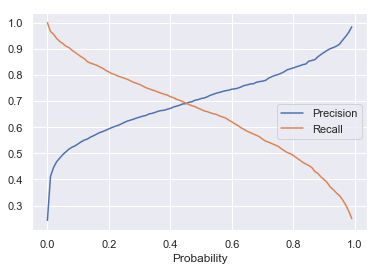

In [141]:
cutoff_df.plot.line(x='Probability', y=['Precision','Recall'])
plt.show()

In [142]:
prob_column='xgb_proba'
prob_cutoff = 0.2
consolidated_proba_df['predicted'] = consolidated_proba_df[prob_column].map(lambda x: 1 if x > prob_cutoff else 0)

local_confusion_matrix = metrics.confusion_matrix(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'] )
        
accuracy = metrics.accuracy_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
precision = metrics.precision_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
recall = metrics.recall_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
f1_score = metrics.f1_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
roc_auc = metrics.roc_auc_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])

print(" Accuracy {0:.3f}, \n Precision {1:.3f}, \n Recall {2:.3f}, \n f1_score {3:.3f}, \n roc_auc {4:.3f}".format(
    accuracy, precision,recall,f1_score,roc_auc))

 Accuracy 0.819, 
 Precision 0.594, 
 Recall 0.811, 
 f1_score 0.686, 
 roc_auc 0.816


### Plots of new blend

In [124]:
# First(0) column contains prob for 0-class and second(1) contains prob for 1-class
gnb_pred_df = pd.DataFrame({'Actual':consolidated_proba_df['Actual'], 'Probability':consolidated_proba_df['final_blended_proba']}) 
return_dictionary = autoglm.calculateGLMKpis(gnb_pred_df, cutoff_by='Sensitivity-Specificity', include_cutoff_df_in_return=True)
cutoff_df = return_dictionary['cutoff_df']

probability_cutoff:0.28


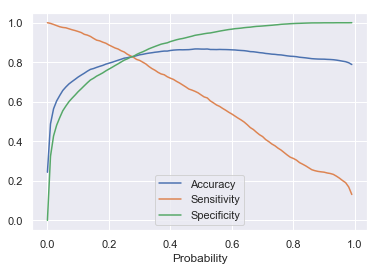

In [125]:
cutoff_df.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity'])
plt.show()

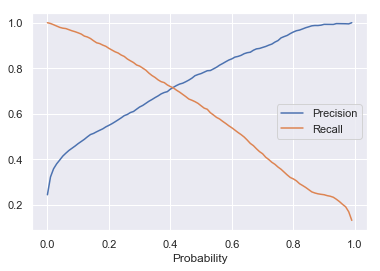

In [126]:
cutoff_df.plot.line(x='Probability', y=['Precision','Recall'])
plt.show()

In [143]:
prob_column='final_blended_proba'
prob_cutoff = 0.28
consolidated_proba_df['predicted'] = consolidated_proba_df[prob_column].map(lambda x: 1 if x > prob_cutoff else 0)

local_confusion_matrix = metrics.confusion_matrix(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'] )
        
accuracy = metrics.accuracy_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
precision = metrics.precision_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
recall = metrics.recall_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
f1_score = metrics.f1_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])
roc_auc = metrics.roc_auc_score(consolidated_proba_df['Actual'], consolidated_proba_df['predicted'])

print(" Accuracy {0:.3f}, \n Precision {1:.3f}, \n Recall {2:.3f}, \n f1_score {3:.3f}, \n roc_auc {4:.3f}".format(
    accuracy, precision,recall,f1_score,roc_auc))

 Accuracy 0.829, 
 Precision 0.610, 
 Recall 0.825, 
 f1_score 0.701, 
 roc_auc 0.827
